# Random Forest Classifier

In [1]:
# Model Resource:  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pathlib import Path
import time
import hvplot.pandas

#Import SKLearn Library and CLasses
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from joblib import dump, load

import yfinance as yf
import pyfolio as pf
from pyfolio import timeseries 
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
print(f'Preparing to train, test, fit, and evaluate the Random Forest Classifier Model...\n')

Preparing to train, test, fit, and evaluate the Random Forest Classifier Model...



In [4]:
# Load model parameter file
df_random_forest_model_param = pd.read_csv('DataFiles/random_forest_model_parameters.csv', index_col=0)
df_random_forest_model_param

RFC_Parameter_Value
RFC_Parameters                              
TrainSplit                               0.7
n_estimators                             500
criterion                               gini
max_depth                               5000
min_samples_split                          2
min_samples_leaf                           1
min_weight_fraction_leaf                   0
max_features                               5
max_leaf_nodes                          None
min_impurity_decrease                      0
bootstrap                               TRUE
oob_score                              FALSE
n_jobs                                  None
random_state                               0
verbose                                    1
warm_start                             FALSE
class_weight                            None
ccp_alpha                                  0
max_samples                                5

In [5]:
# Load lag results from notebook 'rfc_model_optimal_lag.ipynb'
# The results of this notebook should equal the values in 'df_strat_lag' for a given lag value
df_strat_lag = pd.read_csv('AutoOutputFiles/df_strat_lag.csv', index_col=0)
df_strat_lag

FeatureLag  n_estimators  max_depth max_features  random_state  verbose  \
0            1           500       5000         auto             0        1   
1            2           500       5000         auto             0        1   
2            3           500       5000         auto             0        1   
3            4           500       5000         auto             0        1   
4            5           500       5000         auto             0        1   
5            6           500       5000         auto             0        1   
6            7           500       5000         auto             0        1   
7            8           500       5000         auto             0        1   
8            9           500       5000         auto             0        1   
9           10           500       5000         auto             0        1   
10          11           500       5000         auto             0        1   
11          12           500       5000         auto             0        1   
12          13           500       5000         auto             0        1   
13          14           500       5000         auto             0        1   
14          15           500       5000         auto             0        1   
15          16           500       5000         auto             0        1   
16          17           500       5000         auto             0        1   
17          18           500       5000         auto             0        1   
18          19           500       5000         auto             0        1   
19          20           500       5000         auto             0        1   
20          21           500       5000         auto             0        1   
21          22           500       5000         auto             0        1   
22          23           500       5000         auto             0        1   
23          24           500       5000         auto             0        1   
24          25           500       5000         auto             0        1   
25          26           500       5000         auto             0        1   
26          27           500       5000         auto             0        1   
27          28           500       5000         auto             0        1   
28          29           500       5000         auto             0        1   
29          30           500       5000         auto             0        1   

    Annual Return  Annual Volatility  Sharpe Ratio  Calmar Ratio  \
0        0.034738           0.164801      0.290850      0.122693   
1        0.080483           0.159570      0.565565      0.307788   
2        0.078411           0.198310      0.480849      0.260178   
3        0.173428           0.188221      0.943836      0.774875   
4        0.125988           0.195109      0.706470      0.566732   
5        0.142339           0.126600      1.114756      1.151101   
6        0.068490           0.203624      0.427859      0.245267   
7        0.171999           0.139757      1.206102      1.024814   
8        0.119481           0.177548      0.725818      0.365997   
9        0.080678           0.184880      0.512622      0.303148   
10       0.226574           0.189125      1.175209      1.107335   
11       0.120157           0.160992      0.785696      0.677258   
12       0.107574           0.198451      0.615183      0.359822   
13       0.166033           0.159578      1.042617      0.964376   
14       0.073695           0.197967      0.459055      0.230129   
15       0.257014           0.140226      1.701293      2.745141   
16       0.036009           0.170919      0.293538      0.095146   
17       0.075363           0.171468      0.511262      0.241705   
18       0.017699           0.171150      0.189023      0.083390   
19       0.040921           0.163434      0.329438      0.121784   
20       0.195519           0.189950      1.036167      0.671838   
21       0.172344           0.183212      0.959583      1.

In [6]:
# Must have proper index for logic to work correctly
# Lag Value = Index Value + 1 (df_strat_lag index must start at index = 0 and be sequential)
column = df_strat_lag["Annual Return"]
max_value = column.max()
print(f'The highest Average Annualized Return = {max_value:.3%}')
max_index = column.idxmax()
#max_index
print(f'The highest Average Annualized Return Index = {max_index}')

optimal_lag = max_index + 1
print(f'The optimal Feature Lag to produce highest expected Average Annualized Return = {optimal_lag}')

The highest Average Annualized Return = 25.701%
The highest Average Annualized Return Index = 15
The optimal Feature Lag to produce highest expected Average Annualized Return = 16


In [7]:
#################################
#         GLOBAL VARIABLES      #
#################################

# Day's per annum
n = 252
# data shift
signal_shift = optimal_lag
print(f'The Feature Set will be lagged by {signal_shift} days with the objective of maximizing Average Annualized Return')

The Feature Set will be lagged by 16 days with the objective of maximizing Average Annualized Return


In [8]:
# Open signals file for feature set
feature_set_pct_path = Path('AutoOutputFiles/manual_constructed_feature_set_pct.csv')
X = pd.read_csv(feature_set_pct_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
X.head()

BAMLH0A0HYM2  BAMLC0A0CM  BAMLC0A4CBBB  BAMLH0A1HYBB  BAMLH0A3HYC
Date                                                                         
2011-10-20     -0.007792   -0.004115     -0.006826     -0.010345    -0.005216
2011-10-21     -0.023560   -0.016529     -0.010309     -0.022648    -0.022472
2011-10-24     -0.020107   -0.016807     -0.010417     -0.023173    -0.014559
2011-10-25     -0.002736   -0.008547     -0.007018      0.000000    -0.010109
2011-10-26     -0.012346   -0.004310     -0.007067     -0.012774    -0.008641

In [9]:
# Shift DataFrame Index by 1 to ensure we are using current day's values to predict the next days target value and drop NaNs that get produced in the first row from shift
# Used for model purposes

X = X.shift(signal_shift).dropna()

print(f'Feature dataset is ready for use and has a shape of {X.shape}')
X.head()

Feature dataset is ready for use and has a shape of (2468, 5)


BAMLH0A0HYM2  BAMLC0A0CM  BAMLC0A4CBBB  BAMLH0A1HYBB  BAMLH0A3HYC
Date                                                                         
2011-11-11     -0.007792   -0.004115     -0.006826     -0.010345    -0.005216
2011-11-14     -0.023560   -0.016529     -0.010309     -0.022648    -0.022472
2011-11-15     -0.020107   -0.016807     -0.010417     -0.023173    -0.014559
2011-11-16     -0.002736   -0.008547     -0.007018      0.000000    -0.010109
2011-11-17     -0.012346   -0.004310     -0.007067     -0.012774    -0.008641

In [10]:
# Used for plotting and informational purposes only
feature_set_levels_path = Path('AutoOutputFiles/manual_constructed_feature_set_levels.csv')
X_levels = pd.read_csv(feature_set_levels_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
X_levels.head()

BAMLH0A0HYM2  BAMLC0A0CM  BAMLC0A4CBBB  BAMLH0A1HYBB  BAMLH0A3HYC
Date                                                                         
2011-10-19          7.70        2.43          2.93          5.80        13.42
2011-10-20          7.64        2.42          2.91          5.74        13.35
2011-10-21          7.46        2.38          2.88          5.61        13.05
2011-10-24          7.31        2.34          2.85          5.48        12.86
2011-10-25          7.29        2.32          2.83          5.48        12.73

In [11]:
# Shift DataFrame Index by 1 to align with DataFrame = X
# Used for plotting and informational purposes only
X_levels = X_levels.shift(signal_shift).dropna()

print(f'Feature dataset is ready for use and has a shape of {X_levels.shape}')
X_levels.head()

Feature dataset is ready for use and has a shape of (2482, 5)


BAMLH0A0HYM2  BAMLC0A0CM  BAMLC0A4CBBB  BAMLH0A1HYBB  BAMLH0A3HYC
Date                                                                         
2011-11-10          7.70        2.43          2.93          5.80        13.42
2011-11-11          7.64        2.42          2.91          5.74        13.35
2011-11-14          7.46        2.38          2.88          5.61        13.05
2011-11-15          7.31        2.34          2.85          5.48        12.86
2011-11-16          7.29        2.32          2.83          5.48        12.73

In [12]:
# Open daily returns that were constructed in the data prep module

target_set_pct_path = Path('AutoOutputFiles/manual_constructed_target_set_price_returns.csv')
equity_daily_returns = pd.read_csv(target_set_pct_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
equity_daily_returns.head()

EquityPriceReturns
Date                          
2011-10-20            0.004376
2011-10-21            0.018987
2011-10-24            0.012261
2011-10-25           -0.019444
2011-10-26            0.010159

In [13]:
# Construct a data frame with the closing price levels for equity security
tareget_set_levels_path = Path('AutoOutputFiles/manual_constructed_target_set_price_levels.csv')
equity_daily_prices = pd.read_csv(tareget_set_levels_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
equity_daily_prices.head()

EquityPriceLevel
Date                        
2011-10-19         99.735985
2011-10-20        100.172386
2011-10-21        102.074371
2011-10-24        103.325928
2011-10-25        101.316879

In [14]:
# Concatenate the data frames for the trading purposes
df_equity = pd.concat([equity_daily_prices, equity_daily_returns], axis='columns', join='inner')
df_equity

EquityPriceLevel  EquityPriceReturns
Date                                            
2011-10-20        100.172386            0.004376
2011-10-21        102.074371            0.018987
2011-10-24        103.325928            0.012261
2011-10-25        101.316879           -0.019444
2011-10-26        102.346130            0.010159
...                      ...                 ...
2021-10-07        438.660004            0.008646
2021-10-08        437.859985           -0.001824
2021-10-11        434.690002           -0.007240
2021-10-12        433.619995           -0.002462
2021-10-13        435.179993            0.003598

[2512 rows x 2 columns]

In [15]:
# Construct the dependent variable
df_equity['PositiveReturn'] = df_equity['EquityPriceReturns']
df_equity['PositiveReturn'] = np.where(df_equity['EquityPriceReturns'] > 0, 1, 0)
df_equity.head()

EquityPriceLevel  EquityPriceReturns  PositiveReturn
Date                                                            
2011-10-20        100.172386            0.004376               1
2011-10-21        102.074371            0.018987               1
2011-10-24        103.325928            0.012261               1
2011-10-25        101.316879           -0.019444               0
2011-10-26        102.346130            0.010159               1

In [16]:
df_trading_signals = pd.concat([df_equity, X], axis='columns', join='inner')
print(f'The DataFrame named "df_trading_signals" constructed to hold Equity closing price levels, Equity daily returns, indication of positive, 1, and negative, 0, Equity returns.\n')
print(f'"df_trading_signals" has a shape of {df_trading_signals.shape}\n')
df_trading_signals.to_csv('AutoOutputFiles/df_trading_signals_random_forest_version_0001.csv')
df_trading_signals.head()

The DataFrame named "df_trading_signals" constructed to hold Equity closing price levels, Equity daily returns, indication of positive, 1, and negative, 0, Equity returns.

"df_trading_signals" has a shape of (2468, 8)



EquityPriceLevel  EquityPriceReturns  PositiveReturn  \
Date                                                               
2011-11-11        104.289269            0.018822               1   
2011-11-14        103.301231           -0.009474               0   
2011-11-15        103.811729            0.004942               1   
2011-11-16        102.164978           -0.015863               0   
2011-11-17        100.542931           -0.015877               0   

            BAMLH0A0HYM2  BAMLC0A0CM  BAMLC0A4CBBB  BAMLH0A1HYBB  BAMLH0A3HYC  
Date                                                                           
2011-11-11     -0.007792   -0.004115     -0.006826     -0.010345    -0.005216  
2011-11-14     -0.023560   -0.016529     -0.010309     -0.022648    -0.022472  
2011-11-15     -0.020107   -0.016807     -0.010417     -0.023173    -0.014559  
2011-11-16     -0.002736   -0.008547     -0.007018      0.000000    -0.010109  
2011-11-17     -0.012346   -0.004310     -0.007067     -0.012774    -0.008641

## Model

#### Assign Training and Testing Windows

In [17]:
training_start = df_trading_signals.index.min().strftime(format='%Y-%m-%d')

# June 29, 2018 is a Friday
training_end = '2018-12-14'

# Construct testing start and end dates
# July 2, 2018 is the first business day following June 29, 2018
testing_start = '2018-12-15'
testing_end = df_trading_signals.index.max().strftime(format='%Y-%m-%d')

#### Seperate X and Y Training Datasets

In [18]:
x_train = X[training_start:training_end]
y_train = df_trading_signals['PositiveReturn'][training_start:training_end]
#x_train.tail()
#y_train.tail()

In [19]:
# Seperate X and Y Testing Datasets
x_test = X[testing_start:testing_end]
y_test = df_trading_signals['PositiveReturn'][testing_start:testing_end]
#x_test.tail()
#y_test.tail()

#### Random Forest Classifier Paramerters

In [20]:
# n_estimators: int, default=100
#    The number of trees in the forest.

# max_depth: int, default=None.  
#    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

# min_samples_split: int or float, default=2
#    The minimum number of samples required to split an internal node:
#    If int, then consider min_samples_split as the minimum number.
#    If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

# verbose: int, default=0
#    Controls the verbosity when fitting and predicting.

# max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
#    The number of features to consider when looking for the best split:
#    If int, then consider max_features features at each split.
#    If float, then max_features is a fraction and round(max_features * n_features) features are considered at each split.
#    If “auto”, then max_features=sqrt(n_features).
#    If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
#    If “log2”, then max_features=log2(n_features).
#    If None, then max_features=n_features.
#    Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

# Model Parameters
input_n_estimators = int(df_random_forest_model_param.loc['n_estimators'].values)
input_max_depth = int(df_random_forest_model_param.loc['max_depth'].values)
input_max_features = 'auto'
input_random_state = int(df_random_forest_model_param.loc['random_state'].values)
input_min_samples_split = int(df_random_forest_model_param.loc['min_samples_split'].values)
input_verbose = int(df_random_forest_model_param.loc['verbose'].values)    

# Confirm the parameters that are being used for building, training, and testing the model
#print(f'\n')
print(f'-'*55)
print(f'Training Data Sets:')
print(f'Training Start: {training_start}')
print(f'Training End: {training_end}')
print(f'Feature (Indepenendent Variables) Training Size: {len(x_train)}')
print(f'Target (Depenendent Variables) Training Size: {len(y_train)}')

print(f'-'*55)

print(f'Testing Data Sets:')
print(f'Testing Start: {testing_start}')
print(f'Testing End: {testing_end}')
print(f'Feature (Indepenendent Variables) Testing Size: {len(x_test)}')
print(f'Target (Depenendent Variables) Testing Size: {len(y_test)}')

print(f'-'*55)

print(f'The Random Forst Paramerters:')
print(f'n_estimators = {input_n_estimators}')
print(f'max_depth = {input_max_depth}')
print(f'max_max_features = {input_max_features}')
print(f'random_state = {input_random_state}')
print(f'-'*55)
print(f'\n')

-------------------------------------------------------
Training Data Sets:
Training Start: 2011-11-11
Training End: 2018-12-14
Feature (Indepenendent Variables) Training Size: 1756
Target (Depenendent Variables) Training Size: 1756
-------------------------------------------------------
Testing Data Sets:
Testing Start: 2018-12-15
Testing End: 2021-10-13
Feature (Indepenendent Variables) Testing Size: 712
Target (Depenendent Variables) Testing Size: 712
-------------------------------------------------------
The Random Forst Paramerters:
n_estimators = 500
max_depth = 5000
max_max_features = auto
random_state = 0
-------------------------------------------------------




#### Instantiate, Define, & fit the model

In [21]:
model = RandomForestClassifier(
    n_estimators = input_n_estimators,
    max_depth = input_max_depth, 
    max_features = input_max_features, 
    random_state = input_random_state,
    min_samples_split = input_min_samples_split,
    verbose = input_verbose
)
model.fit(x_train, y_train)

# Make a prediction of "y" values from the x test dataset
predictions = model.predict(x_test)

# Assesmble actual y data (y_test) with predicted y data (from just above) into two columns in a dataframe:
results = y_test.to_frame()
results['PredictedValue'] = predictions
results.to_csv('AutoOutputFiles/results_testing.csv')

# Add a difference column to data frame, then plot to better visualize when actual and predicted are NOT equal
results['PredictedMinusActual'] = results['PredictedValue'] - results['PositiveReturn']
results.tail()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


PositiveReturn  PredictedValue  PredictedMinusActual
Date                                                            
2021-10-07               1               0                    -1
2021-10-08               0               0                     0
2021-10-11               0               1                     1
2021-10-12               0               0                     0
2021-10-13               1               0                    -1

#### Determine Feature Importance using MDI

Gini Importance or Mean Decrease in Impurity (MDI) calculates each feature importance as the sum over the number of splits (across all tress) that include the feature, 
proportionally to the number of samples it splits.  In scikit-learn, it is sometimes called “gini importance” or “mean decrease impurity” and is defined as the total decrease
in node impurity weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.


The blue bars are the feature importances of the forest, along with their inter-trees variability represented by the error bars.
Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

Elapsed time to compute the importances: 0.041 seconds


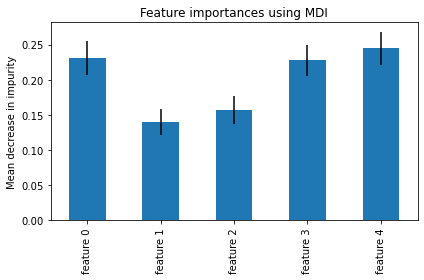

In [22]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
# https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3
feature_names = [f'feature {i}' for i in range(X.shape[1])]
feature_names

msg = (f'Gini Importance or Mean Decrease in Impurity (MDI) calculates each feature importance as the sum over the number of splits (across all tress) that include the feature, \n')
msg += (f'proportionally to the number of samples it splits.  ')
msg += (f'In scikit-learn, it is sometimes called “gini importance” or “mean decrease impurity” and is defined as the total decrease\nin node impurity ') 
msg += (f'weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.\n\n')
print(msg)

start_time = time.time()
importances = model.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time
print(f'The blue bars are the feature importances of the forest, along with their inter-trees variability represented by the error bars.')
print(f'Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.')
print(f'\nElapsed time to compute the importances: '
      f'{elapsed_time:.3f} seconds')

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [23]:
df_trading_signals.drop(columns=['PositiveReturn'], inplace=True)

df_performance_results = pd.concat([results, df_trading_signals], axis='columns', join='inner')
df_performance_results['Equity_Position'] = df_performance_results['PredictedValue'] * df_performance_results['EquityPriceReturns']
df_performance_results['Strategy_Cum_Rtn'] = ( 1 + df_performance_results['Equity_Position']).cumprod()
df_performance_results['Equity_Cum_Rtn'] = ( 1 + df_performance_results['EquityPriceReturns']).cumprod()
#df_performance_results['Treasury'] = sector_daily_returns['SPTS']
df_performance_results.to_csv('AutoOutputFiles/df_performance_results_random_forest.csv')
df_performance_results.tail()

PositiveReturn  PredictedValue  PredictedMinusActual  \
Date                                                               
2021-10-07               1               0                    -1   
2021-10-08               0               0                     0   
2021-10-11               0               1                     1   
2021-10-12               0               0                     0   
2021-10-13               1               0                    -1   

            EquityPriceLevel  EquityPriceReturns  BAMLH0A0HYM2  BAMLC0A0CM  \
Date                                                                         
2021-10-07        438.660004            0.008646     -0.009646    0.000000   
2021-10-08        437.859985           -0.001824     -0.006494    0.000000   
2021-10-11        434.690002           -0.007240     -0.006536    0.000000   
2021-10-12        433.619995           -0.002462      0.062500    0.011111   
2021-10-13        435.179993            0.003598     -0.018576    0.000000   

            BAMLC0A4CBBB  BAMLH0A1HYBB  BAMLH0A3HYC  Equity_Position  \
Date                                                                   
2021-10-07      0.000000     -0.018779    -0.009302          0.00000   
2021-10-08     -0.008929     -0.004785    -0.001565         -0.00000   
2021-10-11     -0.009009     -0.004808    -0.006270         -0.00724   
2021-10-12      0.018182      0.072464     0.045741         -0.00000   
2021-10-13      0.000000     -0.013514    -0.010558          0.00000   

            Strategy_Cum_Rtn  Equity_Cum_Rtn  
Date                                          
2021-10-07          1.922343        1.775453  
2021-10-08          1.922343        1.772215  
2021-10-11          1.908426        1.759385  
2021-10-12          1.908426        1.755054  
2021-10-13          1.908426        1.761368

In [24]:
total_days = df_performance_results['PredictedValue'].count()
print(f'The total number of days in the testing period = {total_days}')

total_pos_days = df_performance_results.loc[(df_performance_results['PositiveReturn'] == 1), 'PositiveReturn'].sum()
total_pos_days_pct = total_pos_days / total_days
total_pos_days_pct
print(f'The total number of postive return days in the testing period = {total_pos_days} or {total_pos_days_pct:.3%} of total days')

total_neg_days = total_days - total_pos_days
total_neg_days_pct = total_neg_days / total_days
print(f'The total number of postive return days in the testing period = {total_neg_days} or {total_neg_days_pct:.3%} of total days')

strat_days_invested = df_performance_results['PredictedValue'].sum()
strat_days_invested_pct = strat_days_invested / total_days
print(f'The strategy had a long positions in the equity on {strat_days_invested} or {strat_days_invested_pct:.3%} of total days')

strat_days_in_cash = total_days - strat_days_invested
strat_days_in_cash_pct = 1 - strat_days_invested_pct
print(f'The strategy had long positions in cash on {strat_days_in_cash} or {strat_days_in_cash_pct:.3%} of total days')

strat_days_invested_positive = df_performance_results.loc[(df_performance_results['PositiveReturn'] == 1) & (df_performance_results['PredictedValue'] == 1), 'PredictedValue'].count()
strat_days_invested_positive_pct = strat_days_invested_positive / total_pos_days
print(f'The strategy captured {strat_days_invested_positive} of the equities postive return days or {strat_days_invested_positive_pct:.3%}')

strat_days_invested_negative = df_performance_results.loc[(df_performance_results['PositiveReturn'] == 0) & (df_performance_results['PredictedValue'] == 0), 'PredictedValue'].count()
strat_days_invested_negative_pct = strat_days_invested_negative / total_neg_days

print(f'The strategy captured {strat_days_invested_negative} of the equities negative return days or {strat_days_invested_negative_pct:.3%}')

The total number of days in the testing period = 712
The total number of postive return days in the testing period = 410 or 57.584% of total days
The total number of postive return days in the testing period = 302 or 42.416% of total days
The strategy had a long positions in the equity on 404 or 56.742% of total days
The strategy had long positions in cash on 308 or 43.258% of total days
The strategy captured 237 of the equities postive return days or 57.805%
The strategy captured 135 of the equities negative return days or 44.702%


In [25]:
# Retain should Pyfolio fail.  Only retaining in this module and deleting code block from other random forest model versions
# Calculate Full Period Risk Adjusted Performance Results

#annualized_return_strategy = df_performance_results['Equity_Position'].mean() * n
#annualized_return_Equity = df_performance_results['daily_return'].mean() * n

#annualized_vol_strategy = df_performance_results['Equity_Position'].std() * np.sqrt(n)
#annualized_vol_Equity = df_performance_results['daily_return'].std() * np.sqrt(n)

#sharpe_ratio_strategy = annualized_return_strategy / annualized_vol_strategy
#sharpe_ratio_Equity = annualized_return_Equity / annualized_vol_Equity

#variance_strategy = df_performance_results['Equity_Position'].var()
#variance_Equity = df_performance_results['daily_return'].var()

#beta_strategy = df_performance_results['Equity_Position'].cov(df_performance_results['daily_return']) / variance_Equity

In [26]:
# Retain should Pyfolio fail.  Only retaining in this module and deleting code block from other random forest model versions
# As long as Pyfolio continues to work, the following is not required

#dash_size = 55

#print(f'_'*dash_size)
#print()
#print(f'FULL TEST PERIOD PERFORMANCE RESULTS\nVALIDATE PYFOLIO & INCLUDES BETA')
#print(f'_'*dash_size)
#print(f'Strategy Annualized Return     = {annualized_return_strategy}')
#print(f'Equity Annualized Return          = {annualized_return_Equity}')
#print(f'-'*dash_size)
#print(f'Strategy Annualized Volatility = {annualized_vol_strategy}')
#print(f'Equity Annualized Volatility      = {annualized_vol_Equity}')
#print(f'-'*dash_size)
#print(f'Strategy Annualized SR         = {sharpe_ratio_strategy}')
#print(f'Equity Annualized SR              = {sharpe_ratio_Equity}')
#print(f'-'*dash_size)
#print(f'Strategy Beta                  = {beta_strategy}')
#print(f'_'*dash_size)

In [27]:
# Highlights text on Master_Algo_Notebook.ipynb
print("\033[1;37;40m \033[2;37:40m          PYFOLIO PERFORMANCE TEAR SHEETS          \033[0;37;40m")

 [2;37:40m          PYFOLIO PERFORMANCE TEAR SHEETS          


In [28]:
# Modify data frame dates to confirm to Pyfolio date requirements
df = df_performance_results
df = df.tz_localize("UTC")

In [29]:
algo_performance_series = df['Equity_Position']
Equity_performance_series = df['EquityPriceReturns']

perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=algo_performance_series, factor_returns=Equity_performance_series, positions=None, transactions=None, turnover_denom="USD")
perf_stats_all.to_csv('AutoOutputFiles/random_forest_model_1_pyfolio_performance.csv')

In [30]:
print(f'\n\nTRADING ALGO TEST PERIOD PERFORMANCE RESULTS FROM PYFOLIO:\n{perf_stats_all}')



TRADING ALGO TEST PERIOD PERFORMANCE RESULTS FROM PYFOLIO:
Annual return           0.257014
Cumulative returns      0.908426
Annual volatility       0.140226
Sharpe ratio            1.701293
Calmar ratio            2.745141
Stability               0.875154
Max drawdown           -0.093625
Omega ratio             1.540840
Sortino ratio           2.825604
Skew                    1.640559
Kurtosis               21.390373
Tail ratio              1.135482
Daily value at risk    -0.016720
Alpha                   0.163692
Beta                    0.384282
dtype: float64


In [31]:
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=Equity_performance_series, factor_returns=Equity_performance_series, positions=None, transactions=None, turnover_denom="USD")
perf_stats_all.to_csv('AutoOutputFiles/random_forest_Equity_pyfolio_performance.csv')

In [32]:
print(f'\n\nEquity TEST PERIOD PERFORMANCE RESULTS FROM PYFOLIO:\n{perf_stats_all}')



Equity TEST PERIOD PERFORMANCE RESULTS FROM PYFOLIO:
Annual return           0.221840
Cumulative returns      0.761368
Annual volatility       0.226273
Sharpe ratio            0.999652
Calmar ratio            0.657942
Stability               0.856555
Max drawdown           -0.337173
Omega ratio             1.231672
Sortino ratio           1.386887
Skew                   -0.703065
Kurtosis               14.593711
Tail ratio              0.806881
Daily value at risk    -0.027610
Alpha                   0.000000
Beta                    1.000000
dtype: float64


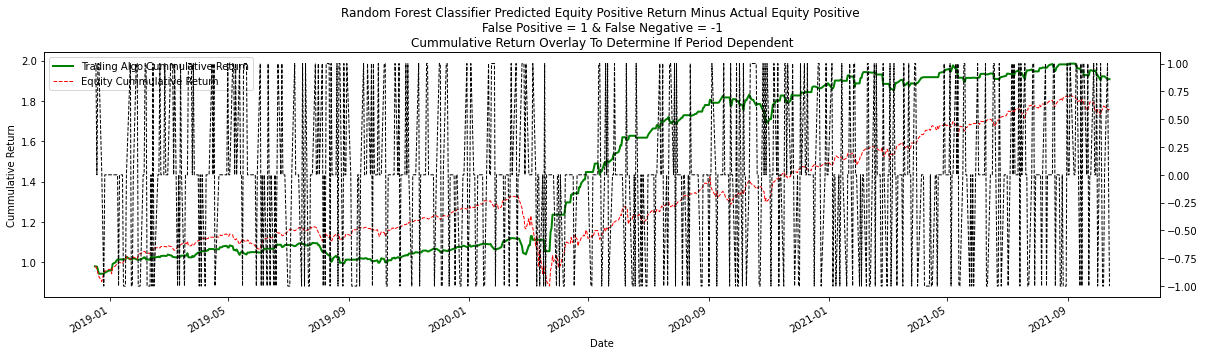

In [33]:
ax = df_performance_results['Strategy_Cum_Rtn'].plot(
    kind='line', label='Trading Algo Cummulative', legend=True, 
    title='Random Forest Classifier Predicted Equity Positive Return Minus Actual Equity Positive \nFalse Positive = 1 & False Negative = -1\nCummulative Return Overlay To Determine If Period Dependent', 
    secondary_y=False, 
    linewidth=2, 
    style='g', 
    figsize=(20,5)
)

ax2 = df_performance_results['Equity_Cum_Rtn'].plot(
    kind='line', 
    label='Equity Cummulative Return', 
    legend=True, 
    secondary_y=False, 
    linestyle='dashed', 
    linewidth=1, 
    style='r', 
    figsize=(20,5)
)

ax3 = df_performance_results['PredictedMinusActual'].plot(
    kind='line', 
    label='Equity Cummulative Return', 
    legend=True, 
    secondary_y=True, 
    linestyle='dashed', 
    linewidth=1, 
    style='black', 
    figsize=(20,5)
)


ax.legend(loc=0)
ax.set_ylabel('Cummulative Return')

ax.legend(
    [
        'Trading Algo Cummulative Return',
        'Equity Cummulative Return'
    ]
)

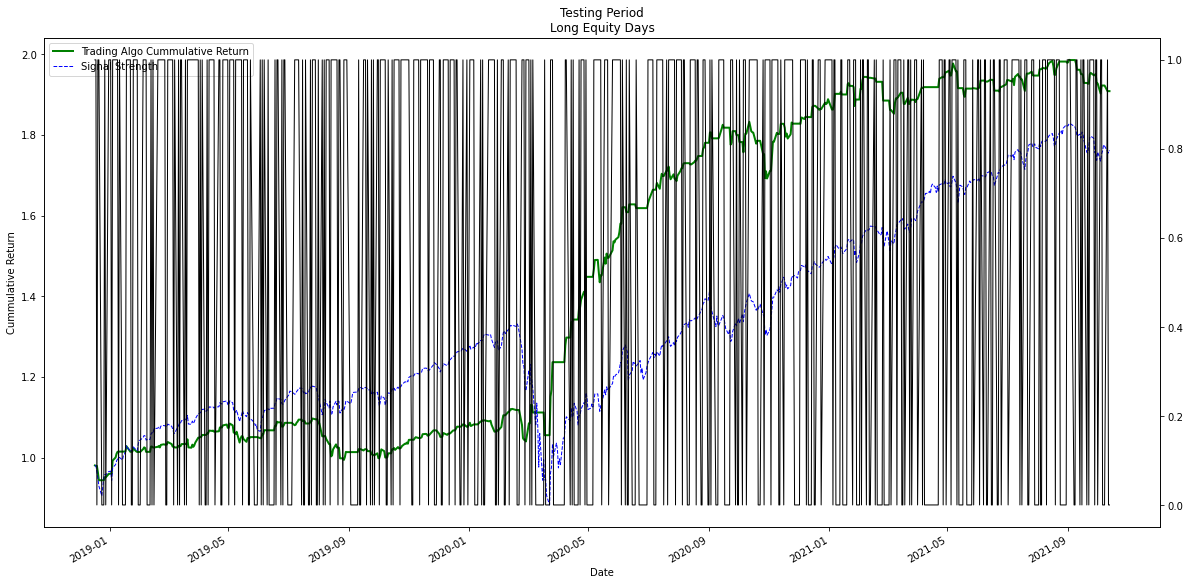

In [34]:
ax = df_performance_results['Strategy_Cum_Rtn'].plot(
    kind='line', label='Trading Algo Cummulative', legend=True, 
    title='Testing Period\nLong Equity Days', secondary_y=False, linewidth=2, style='g', figsize=(20,10))

ax2 = df_performance_results['Equity_Cum_Rtn'].plot(
    kind='line', label='Equity Cummulative Return', legend=True, secondary_y=False, linestyle='dashed', linewidth=1, style='b', figsize=(20,10))

ax3 = df_performance_results['PredictedValue'].plot(
    kind='line', label='Equity Cummulative Return', legend=True, secondary_y=True, linewidth=1, style='black', figsize=(20,10))


ax.legend(loc=0)
ax.set_ylabel('Cummulative Return')

ax.legend(
    [
        'Trading Algo Cummulative Return',
        'Signal Strength'
    ]
)

In [35]:
print("\033[1;37;40m \033[2;37:40m Random Forest Classifier Trading Algo Testing Period  \033[0;37;40m")
print("\033[1;37;40m \033[2;37:40m             Pyfolio Performance Tear Sheet            \033[0;37;40m")
print('')

 [2;37:40m Random Forest Classifier Trading Algo Testing Period  
 [2;37:40m             Pyfolio Performance Tear Sheet            



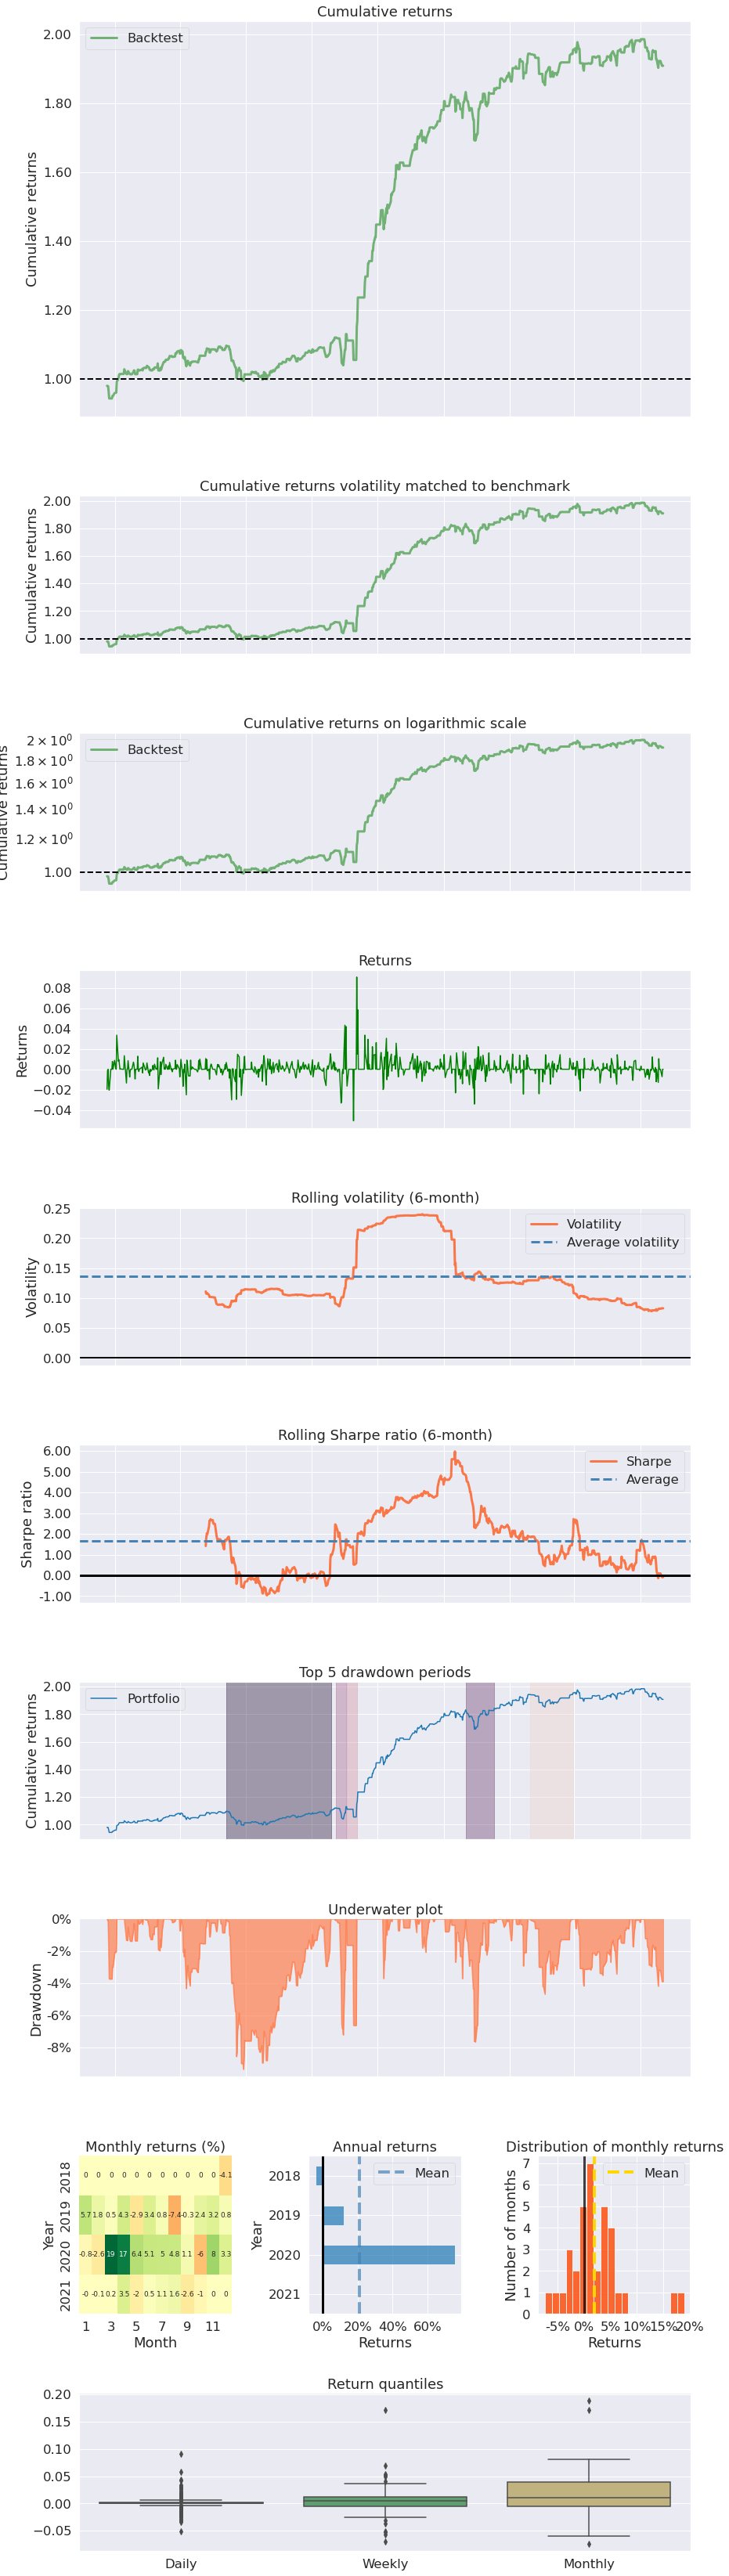

In [36]:
pf.create_returns_tear_sheet(algo_performance_series)

In [37]:
print('\n')
print("\033[1;37;40m \033[2;37:40m                   Equity Testing Period                  \033[0;37;40m")
print("\033[1;37;40m \033[2;37:40m             Pyfolio Performance Tear Sheet            \033[0;37;40m")
print('')



 [2;37:40m                   Equity Testing Period                  
 [2;37:40m             Pyfolio Performance Tear Sheet            



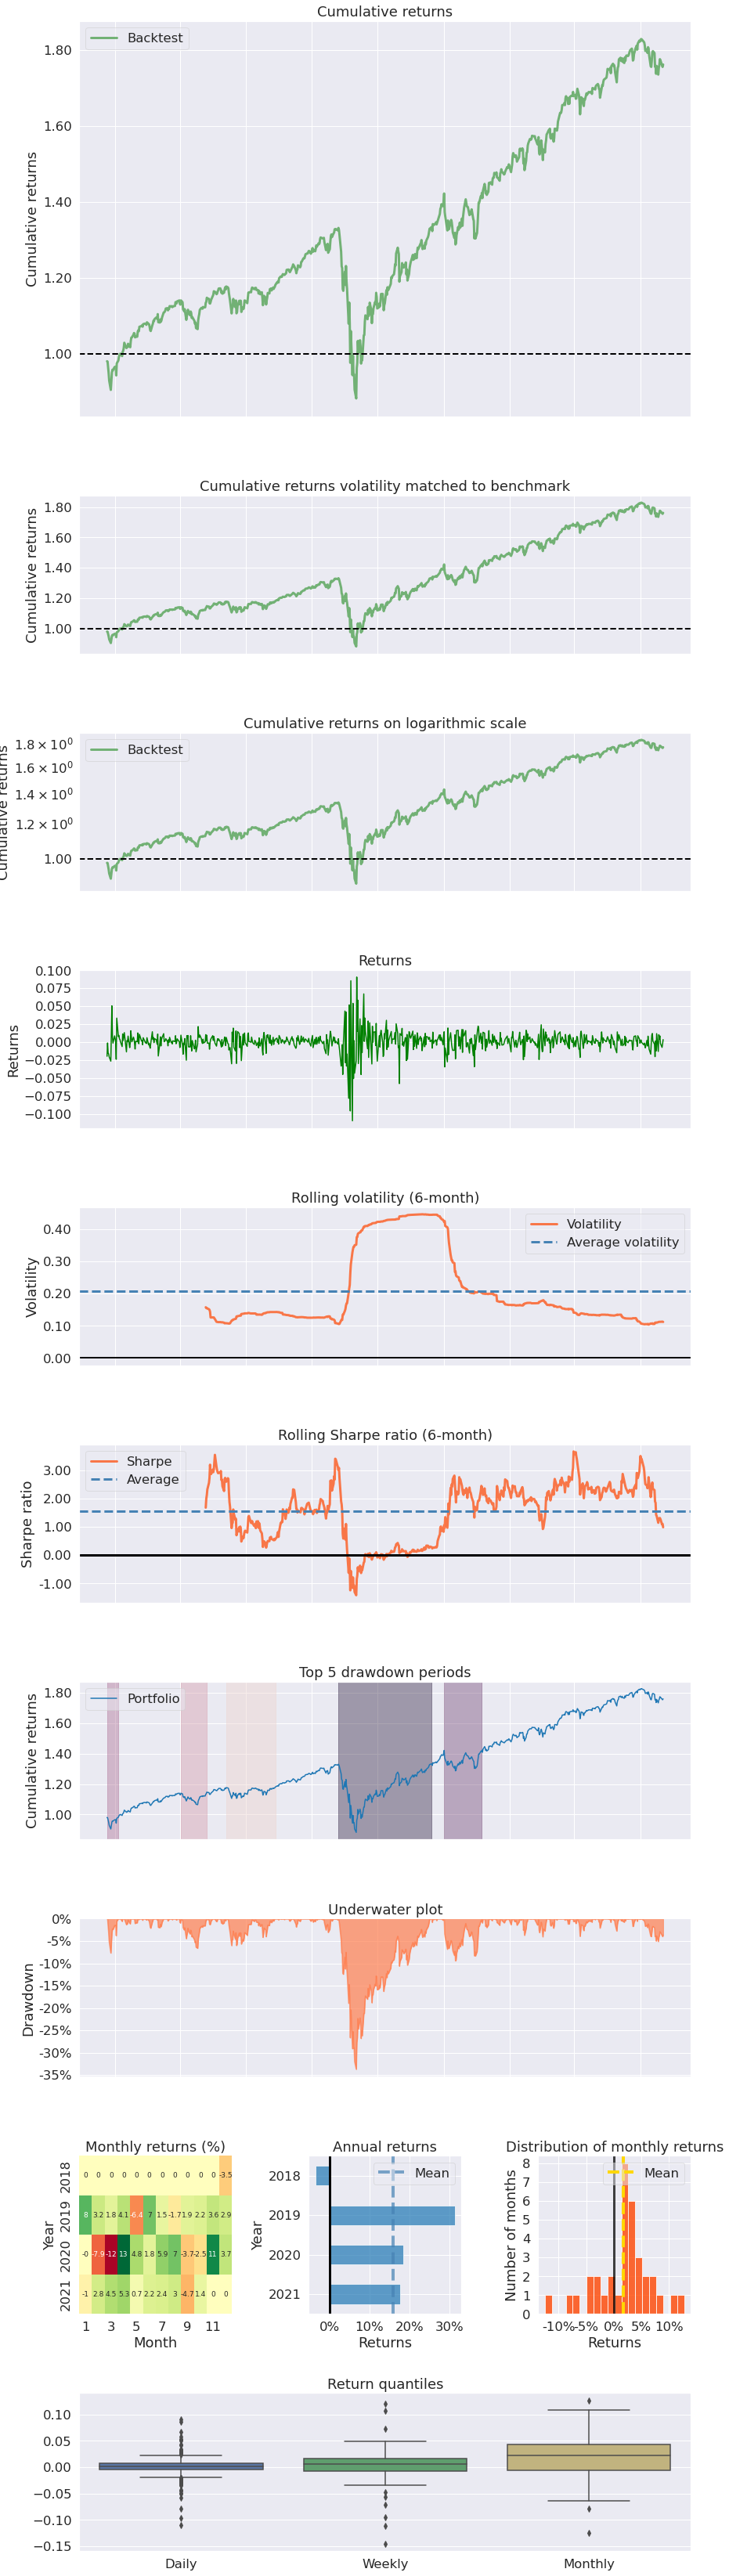

In [38]:
pf.create_returns_tear_sheet(Equity_performance_series)

In [39]:
# Retain in the event that Pyfolio fails
# Not required as long as pyfolio is working correctly

#ax = df_performance_results['Strategy_Cum_Rtn'].plot(
#    kind='line', label='Trading Algo Cummulative', legend=True, 
#    title='Testing Period\nTrading Algo vs. Equity Cummulative Return', secondary_y=False, linewidth=2, style='g', figsize=(20,5))

#ax2 = df_performance_results['Equity_Cum_Rtn'].plot(
#    kind='line', label='Equity Cummulative Return', secondary_y=False, legend=True, linestyle='dashed', linewidth=1, style='r', figsize=(20,5))

#ax.legend(loc=0)
#ax.set_ylabel('Cummulative Return')

#ax2.legend(loc=3)
#ax2.set_ylabel('Cummulative Return')

#ax.legend(
#    [
#        'Trading Algo Cummulative Return',
#        'Equity Cummulative Return'
#    ]
#)

In [40]:
# Define the performance measure window size for calcuation and plotting
measure_window_size_1 = 20
measure_window_size_2 = 60

# Calculate performance measures

# rolling covariance
strat_roll_period_1_covar_Equity = df_performance_results['Equity_Position'].rolling(window=measure_window_size_1).cov(df_performance_results['EquityPriceReturns'])
strat_roll_period_2_covar_Equity = df_performance_results['Equity_Position'].rolling(window=measure_window_size_2).cov(df_performance_results['EquityPriceReturns'])

# rolling variance
strat_roll_period_1_var = df_performance_results['Equity_Position'].rolling(window=measure_window_size_1).var()
strat_roll_period_2_var = df_performance_results['Equity_Position'].rolling(window=measure_window_size_2).var()
Equity_roll_period_1_var = df_performance_results['EquityPriceReturns'].rolling(window=measure_window_size_1).var()
Equity_roll_period_2_var = df_performance_results['EquityPriceReturns'].rolling(window=measure_window_size_2).var()

# rolling standard deviation
strat_roll_period_1_std = df_performance_results['Equity_Position'].rolling(window=measure_window_size_1).std()
strat_roll_period_2_std = df_performance_results['Equity_Position'].rolling(window=measure_window_size_2).std()
Equity_roll_period_1_std = df_performance_results['EquityPriceReturns'].rolling(window=measure_window_size_1).std()
Equity_roll_period_2_std = df_performance_results['EquityPriceReturns'].rolling(window=measure_window_size_2).std()

# rolling mean
strat_roll_period_1_mean = df_performance_results['Equity_Position'].rolling(window=measure_window_size_1).mean()
strat_roll_period_2_mean = df_performance_results['Equity_Position'].rolling(window=measure_window_size_2).mean()
Equity_roll_period_1_mean = df_performance_results['EquityPriceReturns'].rolling(window=measure_window_size_1).mean()
Equity_roll_period_2_mean = df_performance_results['EquityPriceReturns'].rolling(window=measure_window_size_2).mean()


# rolling beta
strat_roll_period_1_beta = strat_roll_period_1_covar_Equity / Equity_roll_period_1_var
strat_roll_period_2_beta = strat_roll_period_2_covar_Equity / Equity_roll_period_2_var

# rolling sharpe ratio (not annualized; reflects the period sharpe ratio)
strat_roll_period_1_sharpe = strat_roll_period_1_mean / strat_roll_period_1_std
strat_roll_period_2_sharpe = strat_roll_period_2_mean / strat_roll_period_2_std
Equity_roll_period_1_sharpe = Equity_roll_period_1_mean / Equity_roll_period_1_std
Equity_roll_period_2_sharpe = Equity_roll_period_2_mean / Equity_roll_period_2_std

In [41]:
def chart_risk_measures_independent(title, performance_measure_name, performance_measure_data, Equity_cum_test_ret, algo_cum_test_ret):
    #chart_risk_measures(title, 'Beta', strat_roll_period_1_beta, strat_roll_period_2_beta, Equity_returns, algo_returns)
    '''
    This function accepts a title as string
    performance_measure as string and used for y_label
    period_1 & period_2 reflect the data containing the time series for which the performance measures
    Equity_cum_test_ret reflects the cummulative return for Equity
    algo_cum_test_ret reflects the cummulative return for the algo
    
    '''
    ax = Equity_cum_test_ret.plot(
        kind = 'line',
        title = title,
        label = 'Equity Cummulative Return',
        secondary_y = False,
        legend = True,
        linewidth = 1,
        style = 'r',
        figsize=(20,5)
    )

    ax2 = algo_cum_test_ret.plot(
        kind='line',
        label='Trading Algo Cummulative',
        legend = True,
        secondary_y = False,
        linewidth = 1,
        style = 'g',
        figsize = (20,5)
    )    
    ax3 = performance_measure_data.plot(
        kind = 'line',
        label = 'Trading Algo Rolling Measure',
        legend = True,
        secondary_y = True,
        linestyle = 'dashed',
        linewidth = 1,
        style = 'b', 
        figsize = (20,5)
    )

    ax.legend(loc=0)
    ax2.legend(loc=0)
    ax3.legend(loc=3)

    ax.set_ylabel('Cummulative Return')
    ax3.set_ylabel(performance_measure_name)                                                    

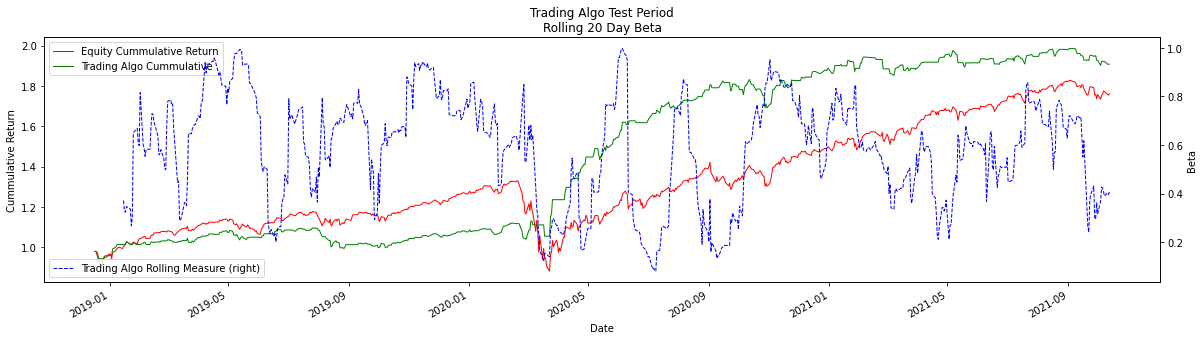

In [42]:
# Plot rolling period beta
title = (f'Trading Algo Test Period\nRolling {measure_window_size_1} Day Beta')
chart_risk_measures_independent(title, 'Beta', strat_roll_period_1_beta, df_performance_results['Equity_Cum_Rtn'], df_performance_results['Strategy_Cum_Rtn'])

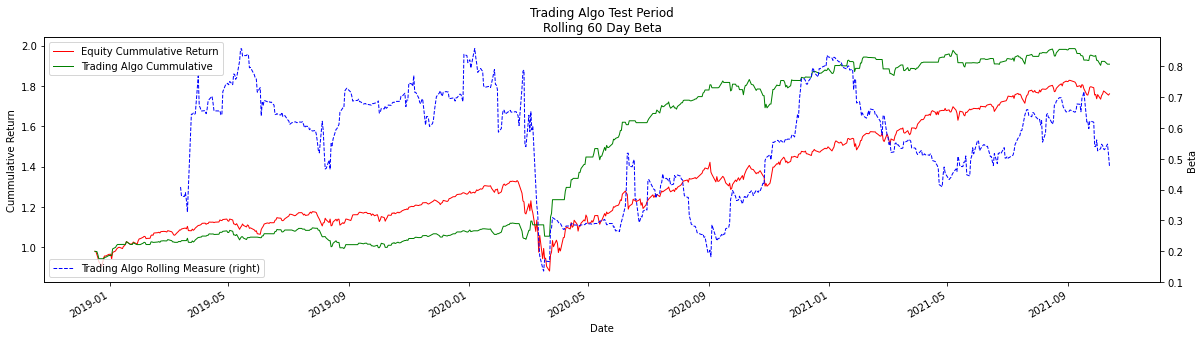

In [43]:
# Plot rolling period beta
title = (f'Trading Algo Test Period\nRolling {measure_window_size_2} Day Beta')
chart_risk_measures_independent(title, 'Beta', strat_roll_period_2_beta, df_performance_results['Equity_Cum_Rtn'], df_performance_results['Strategy_Cum_Rtn'])

In [44]:
def chart_comparables(title, df1, label1, df2, label2):
    '''
    This function accepts a title as string
    performance_measure as string and used for y_label
    period_1 & period_2 reflect the data containing the time series for which the performance measures
    Equity_cum_test_ret reflects the cummulative return for Equity
    algo_cum_test_ret reflects the cummulative return for the algo
    
    '''

    ax = df1.plot(
        kind = 'line',
        title = title,
        label = label1,
        secondary_y = False,
        legend = True,
        linewidth = 1,
        style = 'g',
        figsize=(20,5)
    )

    ax2 = df2.plot(
        kind = 'line',
        label = label2,
        legend = True,
        secondary_y = False,
        linewidth = 1,
        style = 'r',
        figsize = (20,5)
    )    

    ax.legend(loc=0)
    ax2.legend(loc=3)
    ax.set_ylabel('Rolling Period Sharpe Ratio')
    ax2.set_ylabel('Rolling Period Sharpe Ratio')

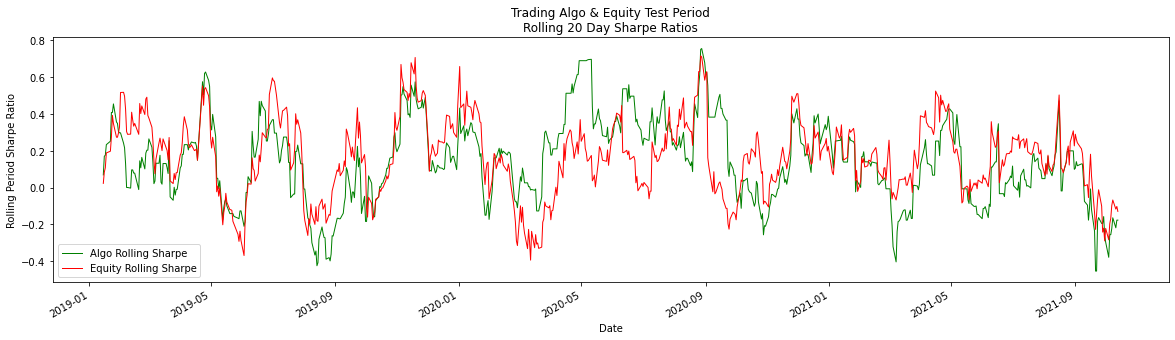

In [45]:
title = (f'Trading Algo & Equity Test Period\nRolling {measure_window_size_1} Day Sharpe Ratios')
label1 = (f'Algo Rolling Sharpe')
label2 = (f'Equity Rolling Sharpe')
chart_comparables(title, strat_roll_period_1_sharpe, label1, Equity_roll_period_1_sharpe, label2)

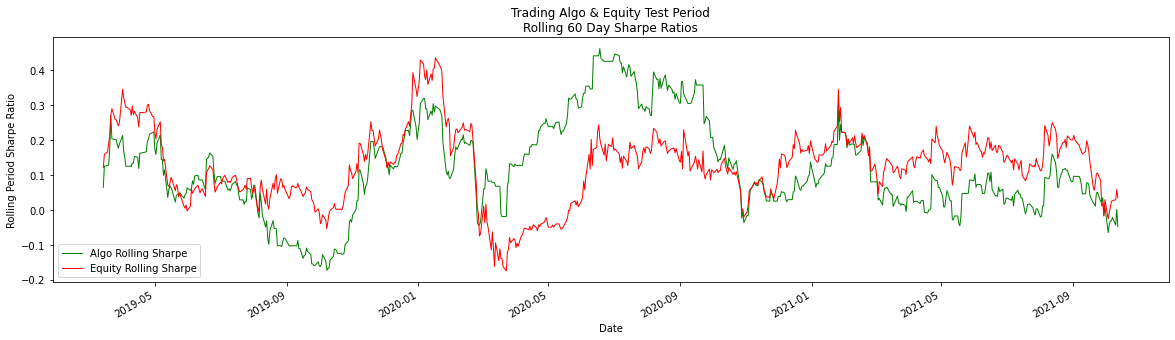

In [46]:
title = (f'Trading Algo & Equity Test Period\nRolling {measure_window_size_2} Day Sharpe Ratios')
label1 = (f'Algo Rolling Sharpe')
label2 = (f'Equity Rolling Sharpe')
chart_comparables(title, strat_roll_period_2_sharpe, label1, Equity_roll_period_2_sharpe, label2)

## Save Trained Model

In [47]:
dump(model, 'model_candidates/random_rorest_model_version_0001.joblib')

['model_candidates/random_rorest_model_version_0001.joblib']